### Deliverable 3: Optimize the Model

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("./Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


### Attempt 1: Adjusting the input data

In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
# Drop SPECIAL_CONSIDERATIONS columns as well
application_df_atp1 = application_df.drop(columns=["EIN", "NAME","SPECIAL_CONSIDERATIONS"])

# Look at APPLICATION_TYPE value counts for binning
application_types = application_df_atp1["APPLICATION_TYPE"].value_counts()
# Determine which values to replace if counts are less than ...?
replace_application = list(application_types[application_types < 500].index)
# Replace in dataframe
for app in replace_application:
    application_df_atp1.APPLICATION_TYPE = application_df_atp1.APPLICATION_TYPE.replace(app,"Other")

# Look at CLASSIFICATION value counts for binning
classifications = application_df_atp1["CLASSIFICATION"].value_counts()
# Determine which values to replace if counts are less than ..?
replace_class = list(classifications[classifications < 1000].index)
# Replace in dataframe
for cls in replace_class:
    application_df_atp1.CLASSIFICATION = application_df_atp1.CLASSIFICATION.replace(cls,"Other")

In [3]:
# Determine the number of unique values in each column.
application_df_atp1.nunique()

APPLICATION_TYPE       9
AFFILIATION            6
CLASSIFICATION         6
USE_CASE               5
ORGANIZATION           4
STATUS                 2
INCOME_AMT             9
ASK_AMT             8747
IS_SUCCESSFUL          2
dtype: int64

In [4]:
# Check ASK_AMT statistics for binning
application_df_atp1["ASK_AMT"].describe()

count    3.429900e+04
mean     2.769199e+06
std      8.713045e+07
min      5.000000e+03
25%      5.000000e+03
50%      5.000000e+03
75%      7.742000e+03
max      8.597806e+09
Name: ASK_AMT, dtype: float64

<AxesSubplot:>

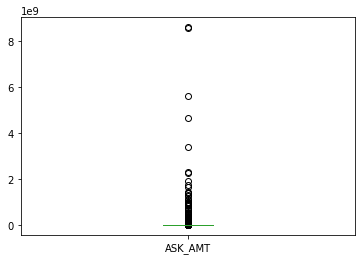

In [5]:
application_df_atp1["ASK_AMT"].plot(kind="box")

In [6]:
# Create bins for ASK_AMT
ask_amount_bins = [0, 5000, 20000, 50000, 100000, 200000, 500000, 2000000, 9000000000]
bin_names = ["<5000", "5000-20000", "20000-50000", "50000-100000", "100000-200000","200000-500000","500000-2000000", ">2000000"]
application_df_atp1["ask_amount"] = pd.cut(application_df_atp1["ASK_AMT"], ask_amount_bins, labels=bin_names)
application_df_atp1.drop(columns="ASK_AMT", inplace=True)
application_df_atp1["ask_amount"].value_counts()

<5000             25398
20000-50000        1609
50000-100000       1423
5000-20000         1338
200000-500000      1175
500000-2000000     1135
100000-200000      1129
>2000000           1092
Name: ask_amount, dtype: int64

In [7]:
# Generate our categorical variable lists
application_cat = application_df_atp1.dtypes[application_df_atp1.dtypes != "int64"].index.tolist()

In [8]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df_atp1[application_cat]))
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
# Merge one-hot encoded features and drop the originals
application_df_atp1 = application_df_atp1.merge(encode_df, left_index=True, right_index=True).drop(columns= application_cat, axis=1)

# Split our preprocessed data into our features and target arrays
y = application_df_atp1["IS_SUCCESSFUL"].values
X = application_df_atp1.drop(columns="IS_SUCCESSFUL", axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [9]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
inputs = len(X_train_scaled[0])
hidden_layer1_nodes = 80
hidden_layer2_nodes = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(input_dim= inputs, units= hidden_layer1_nodes, activation= "relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units= hidden_layer2_nodes, activation= "relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units= 1, activation= "sigmoid"))

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [10]:
# Define the checkpoint path and filename
os.makedirs("checkpoints_optimzation/", exist_ok=True)
checkpoint_path1 = "checkpoints_optimzation/weights_atp1.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 5 epochs.
steps_per_epoch = 804
save_period = 5
callback1 = ModelCheckpoint(filepath=checkpoint_path1, verbose=1, save_weights_only=True, save_freq= int(save_period * steps_per_epoch))

In [11]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100, callbacks=[callback1])

Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.5712 - accuracy: 0.7186
Epoch 2/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5535 - accuracy: 0.7293
Epoch 3/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5494 - accuracy: 0.7317
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5474 - accuracy: 0.7336
Epoch 5/100
802/804 [============================>.] - ETA: 0s - loss: 0.5454 - accuracy: 0.7346
Epoch 5: saving model to checkpoints_optimzation\weights_atp1.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5451 - accuracy: 0.7348
Epoch 6/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5446 - accuracy: 0.7352
Epoch 7/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5434 - accuracy: 0.7366
Epoch 8/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5426 - accuracy: 0.7362
Epoch 9/100
804/804 [================

804/804 [==============================] - 1s 1ms/step - loss: 0.5253 - accuracy: 0.7458
Epoch 64/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5240 - accuracy: 0.7476
Epoch 65/100
789/804 [============================>.] - ETA: 0s - loss: 0.5240 - accuracy: 0.7469
Epoch 65: saving model to checkpoints_optimzation\weights_atp1.65.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5243 - accuracy: 0.7465
Epoch 66/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5249 - accuracy: 0.7463
Epoch 67/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5242 - accuracy: 0.7478
Epoch 68/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5240 - accuracy: 0.7467
Epoch 69/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5241 - accuracy: 0.7464
Epoch 70/100
774/804 [===========================>..] - ETA: 0s - loss: 0.5242 - accuracy: 0.7460
Epoch 70: saving model to checkpoints_optimza

In [12]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5803 - accuracy: 0.7192 - 351ms/epoch - 1ms/step
Loss: 0.5802995562553406, Accuracy: 0.7191836833953857


In [13]:
# Save and export your results to an HDF5 file
nn.save("AlphabetSoupCharity_Optimzation_Attempt1.h5")

### Attempt 2: Adding more neurons to hidden layer + Adding one more hidden layer

In [14]:
# Create a new Datafram for attempt 2 which is same with Deliverable 1

# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df_atp2 = application_df.drop(columns=["EIN", "NAME"])

# Look at APPLICATION_TYPE value counts for binning
application_types = application_df_atp2["APPLICATION_TYPE"].value_counts()
# Determine which values to replace if counts are less than ...?
replace_application = list(application_types[application_types < 500].index)
# Replace in dataframe
for app in replace_application:
    application_df_atp2.APPLICATION_TYPE = application_df_atp2.APPLICATION_TYPE.replace(app,"Other")

# Look at CLASSIFICATION value counts for binning
classifications = application_df_atp2["CLASSIFICATION"].value_counts()
# Determine which values to replace if counts are less than ..?
replace_class = list(classifications[classifications < 1000].index)
# Replace in dataframe
for cls in replace_class:
    application_df_atp2.CLASSIFICATION = application_df_atp2.CLASSIFICATION.replace(cls,"Other")

# Generate our categorical variable lists
application_cat = application_df_atp2.dtypes[application_df_atp2.dtypes == "object"].index.tolist()    

In [15]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df_atp2[application_cat]))
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
# Merge one-hot encoded features and drop the originals
application_df_atp2 = application_df_atp2.merge(encode_df, left_index=True, right_index=True).drop(columns= application_cat, axis=1)

# Split our preprocessed data into our features and target arrays
y = application_df_atp2["IS_SUCCESSFUL"].values
X = application_df_atp2.drop(columns="IS_SUCCESSFUL", axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [16]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
inputs = len(X_train_scaled[0])
hidden_layer1_nodes = 80
hidden_layer2_nodes = 80
hidden_layer3_nodes = 80

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(input_dim= inputs, units= hidden_layer1_nodes, activation= "relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units= hidden_layer2_nodes, activation= "relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units= hidden_layer3_nodes, activation= "relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units= 1, activation= "sigmoid"))

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
# Define the checkpoint path and filename
os.makedirs("checkpoints_optimzation/", exist_ok=True)
checkpoint_path2 = "checkpoints_optimzation/weights_atp2.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 5 epochs.
steps_per_epoch = 804
save_period = 5
callback2 = ModelCheckpoint(filepath=checkpoint_path2, verbose=1, save_weights_only=True, save_freq= int(save_period * steps_per_epoch))

In [18]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,callbacks=[callback2])

Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.5686 - accuracy: 0.7236
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5544 - accuracy: 0.7314
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5513 - accuracy: 0.7345
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5491 - accuracy: 0.7346
Epoch 5/100
775/804 [===========================>..] - ETA: 0s - loss: 0.5471 - accuracy: 0.7353
Epoch 5: saving model to checkpoints_optimzation\weights_atp2.05.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5482 - accuracy: 0.7348
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5472 - accuracy: 0.7361
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5463 - accuracy: 0.7343
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5465 - accuracy: 0.7354
Epoch 9/100
804/804 [================

804/804 [==============================] - 1s 1ms/step - loss: 0.5336 - accuracy: 0.7415
Epoch 64/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5333 - accuracy: 0.7416
Epoch 65/100
789/804 [============================>.] - ETA: 0s - loss: 0.5338 - accuracy: 0.7415
Epoch 65: saving model to checkpoints_optimzation\weights_atp2.65.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5336 - accuracy: 0.7416
Epoch 66/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5337 - accuracy: 0.7414
Epoch 67/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5339 - accuracy: 0.7413
Epoch 68/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5334 - accuracy: 0.7418
Epoch 69/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5333 - accuracy: 0.7414
Epoch 70/100
771/804 [===========================>..] - ETA: 0s - loss: 0.5332 - accuracy: 0.7415
Epoch 70: saving model to checkpoints_optimza

In [19]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5956 - accuracy: 0.7248 - 349ms/epoch - 1ms/step
Loss: 0.5955867171287537, Accuracy: 0.724781334400177


In [20]:
# Save and export your results to an HDF5 file
nn.save("AlphabetSoupCharity_Optimzation_Attempt2.h5")

### Attempt 3: Using different activation functions for hidden layers 

In [21]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
inputs = len(X_train_scaled[0])
hidden_layer1_nodes = 80
hidden_layer2_nodes = 80
hidden_layer3_nodes = 80

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(input_dim= inputs, units= hidden_layer1_nodes, activation= "tanh"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units= hidden_layer2_nodes, activation= "tanh"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units= hidden_layer3_nodes, activation= "tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units= 1, activation= "sigmoid"))

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
# Define the checkpoint path and filename
os.makedirs("checkpoints_optimzation/", exist_ok=True)
checkpoint_path3 = "checkpoints_optimzation/weights_atp3.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 5 epochs.
steps_per_epoch = 804
save_period = 5
callback3 = ModelCheckpoint(filepath=checkpoint_path3, verbose=1, save_weights_only=True, save_freq= int(save_period * steps_per_epoch))

In [23]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,callbacks=[callback3])

Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.5712 - accuracy: 0.7229
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5571 - accuracy: 0.7281
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5541 - accuracy: 0.7314
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5524 - accuracy: 0.7317
Epoch 5/100
772/804 [===========================>..] - ETA: 0s - loss: 0.5495 - accuracy: 0.7333
Epoch 5: saving model to checkpoints_optimzation\weights_atp3.05.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5495 - accuracy: 0.7339
Epoch 6/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5492 - accuracy: 0.7339
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5477 - accuracy: 0.7345
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5462 - accuracy: 0.7353
Epoch 9/100
804/804 [================

804/804 [==============================] - 1s 1ms/step - loss: 0.5330 - accuracy: 0.7411
Epoch 64/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5325 - accuracy: 0.7413
Epoch 65/100
774/804 [===========================>..] - ETA: 0s - loss: 0.5320 - accuracy: 0.7413
Epoch 65: saving model to checkpoints_optimzation\weights_atp3.65.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5325 - accuracy: 0.7410
Epoch 66/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5324 - accuracy: 0.7407
Epoch 67/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5322 - accuracy: 0.7414
Epoch 68/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5322 - accuracy: 0.7414
Epoch 69/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5319 - accuracy: 0.7420
Epoch 70/100
791/804 [============================>.] - ETA: 0s - loss: 0.5330 - accuracy: 0.7408
Epoch 70: saving model to checkpoints_optimza

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5624 - accuracy: 0.7252 - 333ms/epoch - 1ms/step
Loss: 0.5623508095741272, Accuracy: 0.7252478003501892


In [25]:
# Save and export your results to an HDF5 file
nn.save("AlphabetSoupCharity_Optimzation_Attempt3.h5")

### Attempt 4: Combine all options above

- Drop SPECIAL_CONSIDERATIONS column as well
- Change the training size to 0.6
- Add one more hidden layer
- Add more neurons to each hidden layer
- Apply dropout layer to the input and hidden layers 
- Add more batch size to the training regimen

#### 1. Drop SPECIAL_CONSIDERATIONS column 

In [27]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
# Drop SPECIAL_CONSIDERATIONS columns as well
application_df_atp4 = application_df.drop(columns=["EIN", "NAME","SPECIAL_CONSIDERATIONS"])

# Look at APPLICATION_TYPE value counts for binning
application_types = application_df_atp4["APPLICATION_TYPE"].value_counts()
# Determine which values to replace if counts are less than ...?
replace_application = list(application_types[application_types < 500].index)
# Replace in dataframe
for app in replace_application:
    application_df_atp4.APPLICATION_TYPE = application_df_atp4.APPLICATION_TYPE.replace(app,"Other")

# Look at CLASSIFICATION value counts for binning
classifications = application_df_atp4["CLASSIFICATION"].value_counts()
# Determine which values to replace if counts are less than ..?
replace_class = list(classifications[classifications < 1000].index)
# Replace in dataframe
for cls in replace_class:
    application_df_atp4.CLASSIFICATION = application_df_atp4.CLASSIFICATION.replace(cls,"Other")
    
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()     

#### 2. Change the training data size to 0.6

In [31]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df_atp4[application_cat]))
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
# Merge one-hot encoded features and drop the originals
application_df_atp4 = application_df_atp4.merge(encode_df, left_index=True, right_index=True).drop(columns= application_cat, axis=1)

# Split our preprocessed data into our features and target arrays
y = application_df_atp4["IS_SUCCESSFUL"].values
X = application_df_atp4.drop(columns="IS_SUCCESSFUL", axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size=0.6)
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#### 3. Add one more hidden layer
#### 4. Add more neurons to each hidden layer
#### 5. Apply dropout layer to the input and hidden layers

In [48]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
inputs = len(X_train_scaled[0])
hidden_layer1_nodes = 80
hidden_layer2_nodes = 80
hidden_layer3_nodes = 80

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dropout(0.2))
nn.add(tf.keras.layers.Dense(input_dim= inputs, units= hidden_layer1_nodes, activation= "relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dropout(0.2))
nn.add(tf.keras.layers.Dense(units= hidden_layer2_nodes, activation= "relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dropout(0.2))
nn.add(tf.keras.layers.Dense(units= hidden_layer3_nodes, activation= "relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units= 1, activation= "sigmoid"))

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#### 6. Add more batch size to the training regimen

In [49]:
# Define the checkpoint path and filename
os.makedirs("checkpoints_optimzation/", exist_ok=True)
checkpoint_path4 = "checkpoints_optimzation/weights_atp4.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 5 epochs.
batch_size = 515
steps_per_epoch = int(len(X_train_scaled) / batch_size)
save_period = 5
callback4 = ModelCheckpoint(filepath=checkpoint_path4, verbose=1, save_weights_only=True, save_freq= int(save_period * steps_per_epoch))

In [50]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,callbacks=[callback4], batch_size=batch_size,verbose=2)

Epoch 1/100
40/40 - 1s - loss: 0.6531 - accuracy: 0.6352 - 811ms/epoch - 20ms/step
Epoch 2/100
40/40 - 0s - loss: 0.6010 - accuracy: 0.7008 - 165ms/epoch - 4ms/step
Epoch 3/100
40/40 - 0s - loss: 0.5921 - accuracy: 0.7079 - 161ms/epoch - 4ms/step
Epoch 4/100
40/40 - 0s - loss: 0.5884 - accuracy: 0.7089 - 156ms/epoch - 4ms/step
Epoch 5/100

Epoch 5: saving model to checkpoints_optimzation\weights_atp4.05.hdf5
40/40 - 0s - loss: 0.5839 - accuracy: 0.7098 - 178ms/epoch - 4ms/step
Epoch 6/100
40/40 - 0s - loss: 0.5820 - accuracy: 0.7125 - 158ms/epoch - 4ms/step
Epoch 7/100
40/40 - 0s - loss: 0.5814 - accuracy: 0.7129 - 150ms/epoch - 4ms/step
Epoch 8/100
40/40 - 0s - loss: 0.5789 - accuracy: 0.7126 - 154ms/epoch - 4ms/step
Epoch 9/100
40/40 - 0s - loss: 0.5769 - accuracy: 0.7159 - 152ms/epoch - 4ms/step
Epoch 10/100

Epoch 10: saving model to checkpoints_optimzation\weights_atp4.10.hdf5
40/40 - 0s - loss: 0.5770 - accuracy: 0.7145 - 172ms/epoch - 4ms/step
Epoch 11/100
40/40 - 0s - loss: 0.5

40/40 - 0s - loss: 0.5603 - accuracy: 0.7235 - 152ms/epoch - 4ms/step
Epoch 86/100
40/40 - 0s - loss: 0.5623 - accuracy: 0.7218 - 148ms/epoch - 4ms/step
Epoch 87/100
40/40 - 0s - loss: 0.5639 - accuracy: 0.7224 - 152ms/epoch - 4ms/step
Epoch 88/100

Epoch 88: saving model to checkpoints_optimzation\weights_atp4.88.hdf5
40/40 - 0s - loss: 0.5619 - accuracy: 0.7220 - 175ms/epoch - 4ms/step
Epoch 89/100
40/40 - 0s - loss: 0.5617 - accuracy: 0.7218 - 154ms/epoch - 4ms/step
Epoch 90/100
40/40 - 0s - loss: 0.5628 - accuracy: 0.7234 - 151ms/epoch - 4ms/step
Epoch 91/100
40/40 - 0s - loss: 0.5611 - accuracy: 0.7239 - 160ms/epoch - 4ms/step
Epoch 92/100
40/40 - 0s - loss: 0.5619 - accuracy: 0.7238 - 151ms/epoch - 4ms/step
Epoch 93/100

Epoch 93: saving model to checkpoints_optimzation\weights_atp4.93.hdf5
40/40 - 0s - loss: 0.5621 - accuracy: 0.7230 - 178ms/epoch - 4ms/step
Epoch 94/100
40/40 - 0s - loss: 0.5629 - accuracy: 0.7227 - 153ms/epoch - 4ms/step
Epoch 95/100
40/40 - 0s - loss: 0.5614 

In [51]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

429/429 - 1s - loss: 0.5518 - accuracy: 0.7301 - 507ms/epoch - 1ms/step
Loss: 0.551761269569397, Accuracy: 0.7301020622253418


In [52]:
# Save and export your results to an HDF5 file
nn.save("AlphabetSoupCharity_Optimzation_Attempt4.h5")